In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import requests
import io
import pickle
from scipy import stats

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder,MinMaxScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn import metrics
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,StackingClassifier,AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest,chi2
from sklearn import svm
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.utils import class_weight
from imblearn.pipeline import make_pipeline,Pipeline


import warnings
warnings.filterwarnings("ignore")

In [73]:
url = "https://raw.githubusercontent.com/PaleCascade-1/Repository_IOD/main/train.csv"
df = pd.read_csv(url)
df.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


In [74]:
##Dropping Policy ID as it does not add value
df.drop("policy_id",axis=1,inplace=True)

In [75]:
##Extracting Numericals
df["max_torque_Nm"] = df["max_torque"].str.extract(r"([0-9]*\.?[0-9]*)(?=\s*Nm)").astype('float64')
df["max_torque_rpm"]=df["max_torque"].str.extract(r"([0-9]*\.?[0-9]*)(?=\s*rpm)").astype('float64')

df["max_power_bp"]=df["max_power"].str.extract(r"([0-9]*\.?[0-9]*)(?=\s*bhp)").astype("float64")
df["max_power_rpm"]=df["max_power"].str.extract(r"([0-9]*\.?[0-9]*)(?=\s*rpm)").astype("float64")

df.drop(["max_torque","max_power"],axis=1,inplace=True)

In [76]:
##To keep the y-variable intact
claim_df=df["is_claim"]

In [77]:
##To drop is_claim to check z-scores
df.drop("is_claim",axis=1,inplace=True)

In [78]:
##Removing outliers by keeping rows where there are z-scores of less than 3 (absolute), since more than 3 standard deviations away appear to be outliers
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df=df[(np.abs(stats.zscore(df[df.select_dtypes(numerics).columns]))<3).all(axis=1)]

In [79]:
df["is_claim"]=claim_df

In [80]:
df.reset_index(drop=True)

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,engine_type,...,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,max_torque_Nm,max_torque_rpm,max_power_bp,max_power_rpm,is_claim
0,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,F8D Petrol Engine,...,No,No,No,Yes,0,60.0,3500.0,40.36,6000.0,0
1,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,F8D Petrol Engine,...,No,No,No,Yes,0,60.0,3500.0,40.36,6000.0,0
2,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,F8D Petrol Engine,...,No,No,No,Yes,0,60.0,3500.0,40.36,6000.0,0
3,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,1.2 L K12N Dualjet,...,Yes,Yes,Yes,Yes,2,113.0,4400.0,88.50,6000.0,0
4,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,1.0 SCe,...,No,Yes,Yes,Yes,2,91.0,4250.0,67.06,5500.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53860,0.355089,0.13,0.644231,C8,8794,2,A,M3,Petrol,1.0 SCe,...,No,Yes,Yes,Yes,2,91.0,4250.0,67.06,5500.0,0
53861,1.199642,0.02,0.519231,C14,7788,1,A,M1,CNG,F8D Petrol Engine,...,No,No,No,Yes,0,60.0,3500.0,40.36,6000.0,0
53862,1.162273,0.05,0.451923,C5,34738,1,A,M1,CNG,F8D Petrol Engine,...,No,No,No,Yes,0,60.0,3500.0,40.36,6000.0,0
53863,1.236307,0.14,0.557692,C8,8794,1,B2,M6,Petrol,K Series Dual jet,...,Yes,Yes,Yes,Yes,2,113.0,4400.0,88.50,6000.0,0


In [89]:
##Splitting into numericals and categoricals for scaling/encoding
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols=df.select_dtypes(numerics)
cat_cols=df.select_dtypes(exclude=numerics)

In [90]:
##make and ncap_rating are more categorical in nature, not numerical
cat_cols[["make","ncap_rating"]]=df[["make","ncap_rating"]]

In [91]:
num_cols.drop(["ncap_rating","make","is_claim"],axis=1,inplace=True)

In [64]:
num_cols.columns

Index(['policy_tenure', 'age_of_car', 'age_of_policyholder',
       'population_density', 'airbags', 'displacement', 'cylinder', 'gear_box',
       'turning_radius', 'length', 'width', 'height', 'gross_weight',
       'max_torque_Nm', 'max_torque_rpm', 'max_power_bp', 'max_power_rpm'],
      dtype='object')

In [65]:
##Setting target and feature variables
X=df.drop("is_claim",axis=1)
y=df["is_claim"]

In [66]:
##Train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.25,stratify=y)

In [19]:
##Scaling numerical data
scaler=MinMaxScaler()
X_train[num_cols.columns]=scaler.fit_transform(X_train[num_cols.columns])
X_test[num_cols.columns]=scaler.transform(X_test[num_cols.columns])

In [20]:
##SMOTE-ENN to make up for imbalanced dataset
smote=SMOTEENN(random_state=42)
X_train_smote,y_train_smote=smote.fit_resample(X_train,y_train)

In [21]:
##XGBoost
xgbmodel=xgb.XGBClassifier(gamma=0.1,learning_rate=0.3,n_estimators=150,random_state=42)
xgbmodel.fit(X_train_smote,y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [22]:
fpr_test, tpr_test, thresholds = metrics.roc_curve(y_train_smote,xgbmodel.predict_proba(X_train_smote)[:,1],drop_intermediate=False)

In [23]:
min_threshold=thresholds[np.argmin(np.abs(fpr_test+tpr_test-1))]
min_threshold

0.30800962

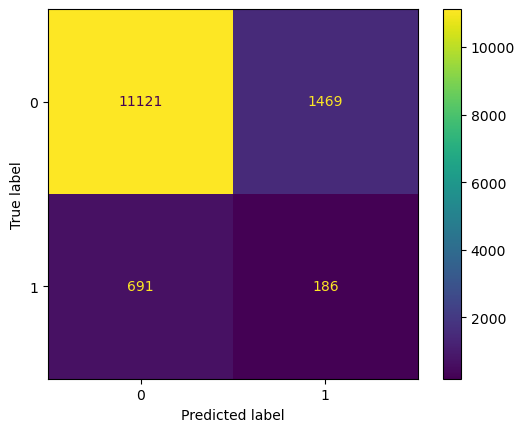

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     12590
           1       0.11      0.21      0.15       877

    accuracy                           0.84     13467
   macro avg       0.53      0.55      0.53     13467
weighted avg       0.89      0.84      0.86     13467



In [24]:
y_pred_xgb_threshold=(xgbmodel.predict_proba(X_test)[:,1]>min_threshold).astype('float')
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_xgb_threshold)
plt.show()
print(classification_report(y_test,y_pred_xgb_threshold))

In [94]:
# pipeline for numerical columns
num_pipe = make_pipeline(
    MinMaxScaler()
)
# pipeline for categorical columns
cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown='ignore', sparse=False)
)

# combine both the pipelines
full_pipe = ColumnTransformer([
    ('num', num_pipe, num_cols.columns),
    ('cat', cat_pipe, cat_cols.columns)
])

pipe=make_pipeline(full_pipe,SMOTEENN(random_state=42),xgb.XGBClassifier(gamma=0.1,learning_rate=0.3,n_estimators=150,random_state=42))

In [97]:
xgbmodel_pipe=pipe.fit(X_train,y_train)

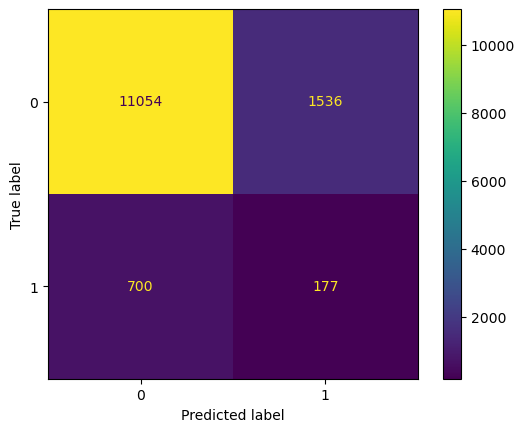

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     12590
           1       0.10      0.20      0.14       877

    accuracy                           0.83     13467
   macro avg       0.52      0.54      0.52     13467
weighted avg       0.89      0.83      0.86     13467



In [101]:
y_pred_xgb=(xgbmodel_pipe.predict_proba(X_test)[:,1]>min_threshold).astype('float')
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_xgb)
plt.show()
print(classification_report(y_test,y_pred_xgb_threshold))

In [104]:
# Save the trained model as a pickle file 
with open('insurance_claim_classifier.pkl', 'wb') as file:
    pickle.dump(xgbmodel_pipe, file)

In [105]:
!pip install imblearn